# EDA NBA History
Through an exploratory analysis of historical NBA data, this project aims to examine the evolution of the game over the years, identifying trends, iconic players and significant changes in the way basketball has been played and enjoyed.

## Data Preparation

In [1]:
library(tidyverse) # metapackage of all tidyverse packages
library(ggplot2)
library(measurements) 
library(fmsb) 
library(ggrepel)
library(stringr)
library(leaflet)

player_stat = read.csv("/kaggle/input/nba-players-data-1950-to-2021/player_data.csv")
nba = read.csv("/kaggle/input/nba-players-data-1950-to-2021/seasons_stats.csv")

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [2]:
nba %>%
  glimpse()

Rows: 28,057
Columns: 51
$ X      <int> 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 1…
$ Year   <int> 1950, 1950, 1950, 1950, 1950, 1950, 1950, 1950, 1950, 1950, 195…
$ Player <chr> "Curly Armstrong", "Cliff Barker", "Leo Barnhorst", "Ed Bartels…
$ Pos    <chr> "G-F", "SG", "SF", "F", "F", "F", "G", "G-F", "F-C", "F-C", "F-…
$ Age    <int> 31, 29, 25, 24, 24, 24, 22, 23, 28, 28, 28, 25, 22, 22, 24, 27,…
$ Tm     <chr> "FTW", "INO", "CHS", "TOT", "DNN", "NYK", "INO", "TRI", "TOT", …
$ G      <int> 63, 49, 67, 15, 13, 2, 60, 3, 65, 36, 29, 57, 60, 59, 62, 61, 4…
$ GS     <int> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA,…
$ MP     <int> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA,…
$ FG     <int> 144, 102, 174, 22, 21, 1, 340, 5, 226, 125, 101, 80, 88, 204, 2…
$ FGA    <int> 516, 274, 499, 86, 82, 4, 936, 16, 813, 435, 378, 248, 305, 600…
$ FG.    <dbl> 0.279, 0.372, 0.349, 0.256, 0.256, 0.250, 0.363, 0.313, 0.278, …
$ X3P    <int> 

In [3]:
player_stat %>%
  glimpse()

Rows: 4,979
Columns: 8
$ Player     <chr> "Alaa Abdelnaby", "Zaid Abdul-Aziz", "Kareem Abdul-Jabbar*"…
$ From       <int> 1991, 1969, 1970, 1991, 1998, 1997, 1977, 1957, 1947, 2017,…
$ To         <int> 1995, 1978, 1989, 2001, 2003, 2008, 1981, 1957, 1948, 2019,…
$ Pos        <chr> "F-C", "C-F", "C", "G", "F", "F", "F", "G", "F", "G-F", "F"…
$ Ht         <chr> "6-10", "6-9", "7-2", "6-1", "6-6", "6-9", "6-7", "6-3", "6…
$ Wt         <int> 240, 235, 225, 162, 223, 225, 220, 180, 195, 200, 225, 185,…
$ Birth.Date <chr> "June 24 1968", "April 7 1946", "April 16 1947", "March 9 1…
$ Colleges   <chr> "Duke", "Iowa State", "UCLA", "LSU", "Michigan San Jose Sta…


When analyzing the null values present in 'player_stat', note how there are only 5 records corresponding to the weight column, which are removed because their presence historically has been marginal.

In [4]:
player_stat %>% 
  select(everything()) %>% 
  summarise_all(list(~sum(is.na(.))))

Player,From,To,Pos,Ht,Wt,Birth.Date,Colleges
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
0,0,0,0,0,5,0,0


In [5]:
player_stat %>%
  filter(is.na(Wt) == T)

Player,From,To,Pos,Ht,Wt,Birth.Date,Colleges
<chr>,<int>,<int>,<chr>,<chr>,<int>,<chr>,<chr>
Dick Lee,1968,1968,F,6-6,NA,,Washington
Murray Mitchell,1950,1950,C,6-6,NA,March 19 1923,Sam Houston State University
Paul Nolen,1954,1954,C,6-10,NA,September 3 1929,Texas Tech
Ray Wertis,1947,1948,G,5-11,NA,July 30 1923,St. John's
Bob Wood,1950,1950,G,5-10,NA,October 7 1921,Northern Illinois


In [6]:
player_stat = player_stat %>%
  drop_na(Wt)

Any duplicates are removed.

In [7]:
player_stat = player_stat %>% 
  distinct(Player, .keep_all = T)

The columns for weight and height are measured in pounds and feet, respectively; for convenience of use we convert the units to kilograms and centimeters.

In [8]:
convertHt <- function(x) {
  heights <- as.character(x)  
  heights_split <- strsplit(heights, "-")  
  feet <- as.numeric(sapply(heights_split, `[`, 1)) 
  inches <- as.numeric(sapply(heights_split, `[`, 2)) 
  heights_cm <- round(conv_unit(feet, "ft", "cm") + conv_unit(inches, "inch", "cm"), 0)
  
  return(heights_cm) 
}

player_stat <- player_stat %>% 
  rowwise() %>% 
  mutate(Ht = convertHt(Ht), Wt = round(conv_unit(Wt, "lbs", "kg")))

player_stat %>%
  select(c(Wt, Ht)) %>%
head(10)

Wt,Ht
<dbl>,<dbl>
109,208
107,206
102,218
73,185
101,198
102,206
100,201
82,190
88,190


Regarding the 'nba' dataset, we remove the rows for the year 2022 because it is the same as the year 2021 and useless columns in order to analysis.

In [9]:
nba = nba %>% 
  filter(Year<2022) 

nba = nba %>% 
  select(-c(X,GS,DWS, OWS,OBPM,DBPM,BPM, PER, X3PAr, FTr, VORP))

Some players' names are flanked by an asterisk to symbolize their presence in the Hall of Fame. For convenience of use, we remove the asterisks and add an appropriate column.

In [10]:
print(nba %>%
  filter(str_detect(nba$Player, ".*\\*$")) %>%
  select(Player) %>%
  head(10))

nba = nba %>%
  mutate(HallOfFame = if_else(str_detect(Player, ".*\\*$"), "Yes", "No"))

nba$Player = gsub("\\*$", "", nba$Player)
player_stat$Player <- gsub("\\*$", "", player_stat$Player)

             Player
1         Al Cervi*
2       Bob Davies*
3        Joe Fulks*
4   Harry Gallatin*
5      Alex Hannum*
6      Red Holzman*
7  Buddy Jeannette*
8      Ed Macauley*
9    Slater Martin*
10    Dick McGuire*


Per-game statistics and FTr (fourth Oliver's factor) are added.

In [11]:
nba = nba %>% 
  mutate(MpG = round(MP/G,3), PpG = round(PTS/G,3), ApG = round(AST/G,3), 
         RpG = round(TRB/G,3), TOpG = round(TOV/G,3), BpG = round(BLK/G,3), 
         SpG = round(STL/G,3),FpG = round(PF/G, 3), .before = 9)

nba = nba %>% 
  mutate(FTr = round(FT/FGA,3), .before = 30)

Positions are redefined.

In [12]:
nba <- nba %>%
  mutate(Pos = case_when(
    Pos == "PF-C" ~ "PF",
    Pos == "C-F" ~ "C",
    Pos == "SF-SG" ~ "SF",
    Pos == "C-PF" ~ "C",
    Pos == "SG-SF" ~ "SG",
    Pos == "PF-SF" ~ "PF",
    Pos == "SF-PF" ~ "SF",
    Pos == "SG-PG" ~ "SG",
    Pos == "SF-PG" ~ "SF",
    Pos == "C-SF" ~ "C",
    Pos == "PG-SG" ~ "PG",
    Pos == "PG-SF" ~ "PG",
    Pos == "SG-PF" ~ "SG",
    Pos == "SF-C" ~ "SF",
    Pos == "F-C" ~ "PF",
    Pos == "F-G" ~ "SF",
    Pos == "G-F" ~ "SF",
    Pos == "F" ~ "PF",
    Pos == "G" ~ "SG",
    TRUE ~ Pos
  ))

PosColorCode <- c("C"="red", "PF"="orange", 
                  "SF"="yellow" ,"SG"="blue", "PG"="green")

table(nba$Pos)


   C   PF   PG   SF   SG 
5351 5786 5194 5372 5649 

At this point the two datasets can be merged to get a comprehensive overview of the information. In addition to that, we also extract two datasets namely '*nba_withTOT*' and '*nba_performance*'. The former excludes partial statistics for those players who changed teams in the middle of the season; while the latter is filtered by minutes and games played.

In [13]:
player_stat = player_stat %>% 
  select(c("Player","Ht", "Wt", "From", "To", "Colleges"))
player_stat = as.data.frame(player_stat)

nba = left_join(nba, player_stat, by = "Player", relationship = "many-to-many")

nba = nba %>% 
  select(Year:Tm, Ht:Colleges, HallOfFame, everything()) 

nba = nba %>% 
  distinct(Player,Year, Tm, Age, .keep_all = T)

nba_withTOT = nba %>%
  group_by(Year, Player) %>%
  mutate(count_tot = sum(Tm == "TOT")) %>%
  filter(count_tot == 0 | (count_tot > 0 & Tm == "TOT")) %>%
  select(-count_tot)

nba_withTOT = as.data.frame(nba_withTOT)

nba_performance = nba %>% 
  distinct(Year, Player, .keep_all = T) %>% 
  filter(MpG > mean(MpG) | G > mean(G))

nba_performance = as.data.frame(nba_performance)

The full dataset contains several null values since not all statistics date back to the same historical period, so from time to time we are going to handle them without removing them. Also in the column for colleges, there are also blank spaces, these may be due to lack of information or because non-American players actually did not belong to any college.

In [14]:
nba_performance %>% 
  summarise_all(list(~sum(is.na(.))))

Year,Player,Pos,Age,Tm,Ht,Wt,From,To,Colleges,⋯,ORB.,DRB.,TRB.,AST.,STL.,BLK.,TOV.,USG.,WS,WS.48
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
0,0,0,0,0,821,821,821,821,821,⋯,2260,2260,1808,1199,2260,2260,2952,2952,24,236


# NBA History
## Colleges

Colleges provide an important springboard for many basketball players who aspire to a professional career in the NBA. These institutions provide opportunities not only to develop technical and athletic skills, but also to mature personally and academically. In addition to their crucial role in training future professionals, colleges are also an important scouting center for NBA teams, which seek to identify emerging talent during college games and tournaments. This close link between academia and the professional world contributes to a particularly vibrant social and cultural fabric around basketball and its practice at the national level. There are 787 different colleges.

In [15]:
player_stat %>%
  filter(is.na(Colleges) != F | Colleges != "") %>%
  distinct(Colleges)%>%
  count()

n
<int>
787


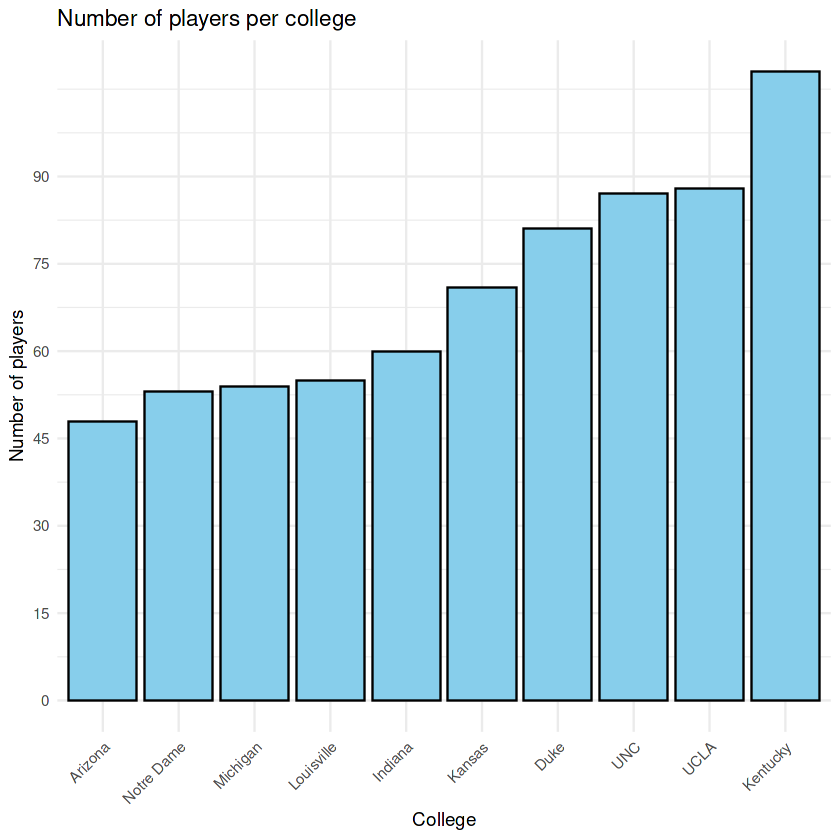

In [16]:
player_stat %>%
  filter(Colleges != "" & !is.na(Colleges)) %>%
  distinct(Colleges, Player) %>%
  count(Colleges, sort = T) %>%
  head(10) %>%
  ggplot(aes(x = reorder(Colleges, n), y = n)) +
  geom_bar(stat = "identity", fill = "skyblue", color = "black") +
  labs(title = "Number of players per college",
       x = "College",
       y = "Number of players") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))+
  scale_y_continuous(breaks = seq(0,100,15))

## Teams
The NBA's expansion strategy for many years was based on the creation of new teams, known as "expansion teams," which gradually increased the number of franchises participating in the league. Initially consisting of 17 teams in the 1949/1950 season, the NBA has seen its number of franchises grow to the current 30.

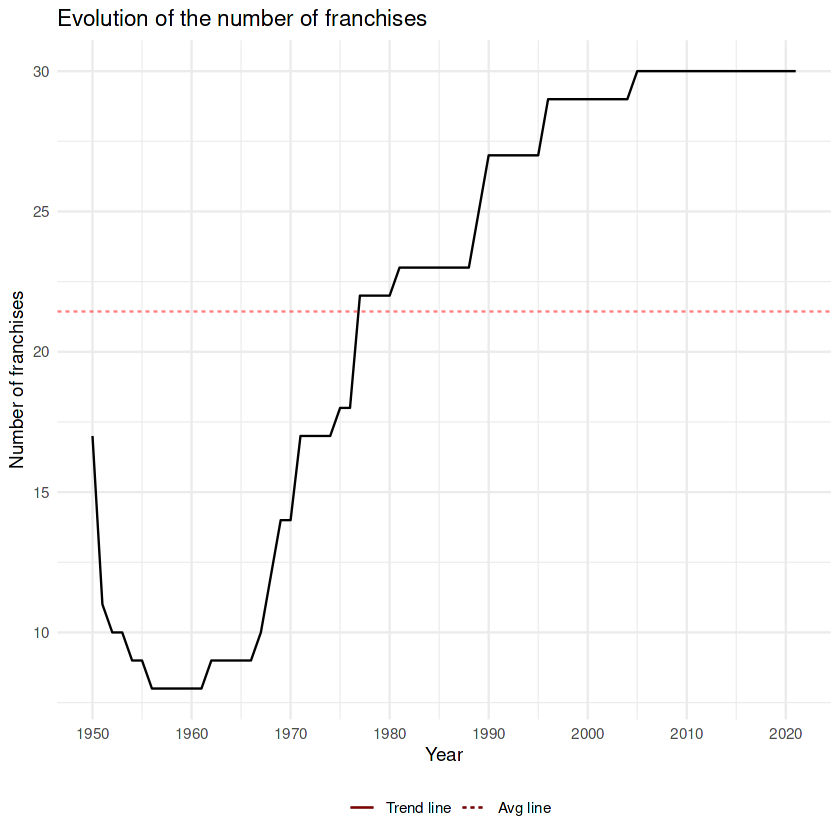

In [17]:
team <- nba %>%
  filter(!Tm == "TOT") %>% 
  group_by(Year) %>%
  summarise(nPlayers = n_distinct(Player), 
            nTeams = n_distinct(Tm), 
            Roster = round(nPlayers/nTeams, 2))

team %>%
  ggplot() +
  geom_line(aes(Year, nTeams, linetype = "Trend line")) +
  ggtitle("Evolution of the number of franchises") +
  geom_hline(aes(yintercept = mean(nTeams), linetype = "Avg line"), col = "red", alpha = 0.5) +
  scale_x_continuous(breaks = seq(1950, 2021, 10)) +
  scale_linetype_manual(name = "", values = c(2, 1), guide = guide_legend(reverse = TRUE)) +
  ylab("Number of franchises") +
  xlab("Year")+
  theme_minimal()+
  theme(legend.position="bottom")

Consequently are incresead also number of player in the league.

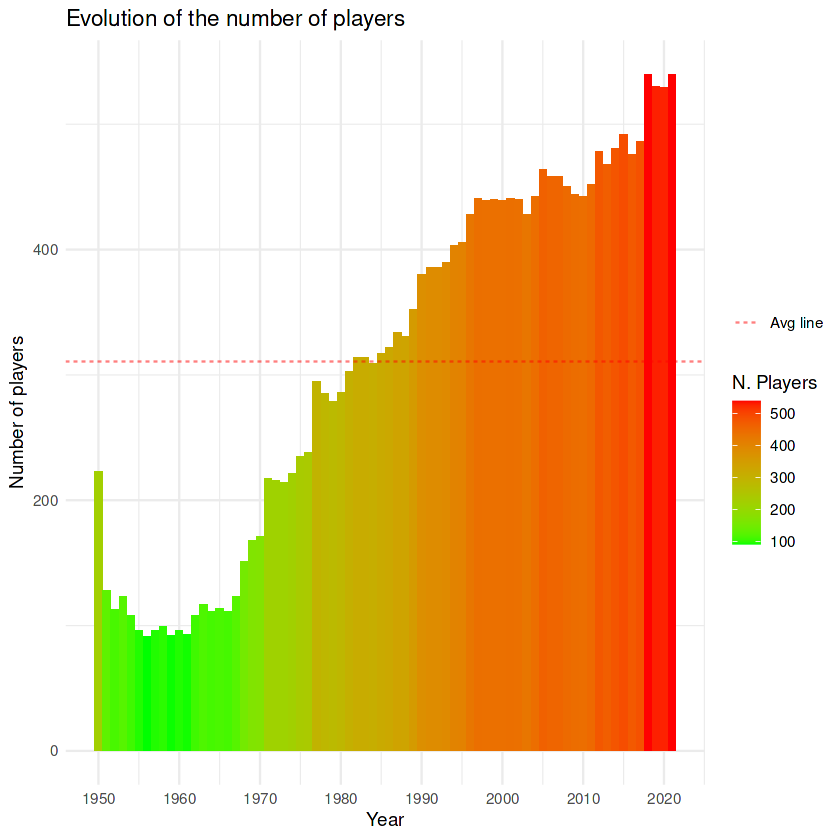

In [18]:
team %>%
  ggplot(aes(Year, nPlayers, fill=nPlayers)) +
  geom_bar(stat = "identity") +
  geom_hline(aes(yintercept = mean(nPlayers), linetype = "Avg line"), col = "red", alpha = 0.5) +
  scale_fill_gradient(name = "N. Players",low = "green", high = "red") +
  scale_x_continuous(breaks = seq(1950, 2021, 10)) +
  scale_linetype_manual(name = "", values = 2) +
  labs(x = "Year", y="Number of players", title="Evolution of the number of players")+
  theme_minimal()

## Transfer
Over the years the number of franchises, commercial revenues, 
thus economic interests have increased we can identify as a direct consequence 
of this the increase in transfers of players during a season.

In [19]:
transfer <- nba %>% 
  select(Tm, Year) %>% 
  filter(Tm == "TOT") %>% 
  group_by(Year) %>% 
  count(sort=T)

Through regression analysis, it can be seen that there is a correlation between years and the increase in transfers.

In [20]:
chisq.test(transfer)
#p.value is minor of 0.05, this means that values aren't independents


	Pearson's Chi-squared test

data:  transfer
X-squared = 937.95, df = 71, p-value < 2.2e-16


In [21]:
mod <- lm(transfer$n~transfer$Year)
summary(mod)
#the dependence of the variables is confirmed by the significance of the two variables 
#the R-squared value tells us that the model fits the data quite well, 
#assuming a value just below 70% 
#A one-unit increase in the year (thus each successive year) 
#is associated with an estimated increase of 0.8458 in the number of transfers 


Call:
lm(formula = transfer$n ~ transfer$Year)

Residuals:
    Min      1Q  Median      3Q     Max 
-22.615  -7.224  -1.968   5.501  39.595 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)   -1.646e+03  1.401e+02  -11.75   <2e-16 ***
transfer$Year  8.458e-01  7.055e-02   11.99   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 12.44 on 70 degrees of freedom
Multiple R-squared:  0.6725,	Adjusted R-squared:  0.6678 
F-statistic: 143.7 on 1 and 70 DF,  p-value: < 2.2e-16


`geom_smooth()` using formula = 'y ~ x'


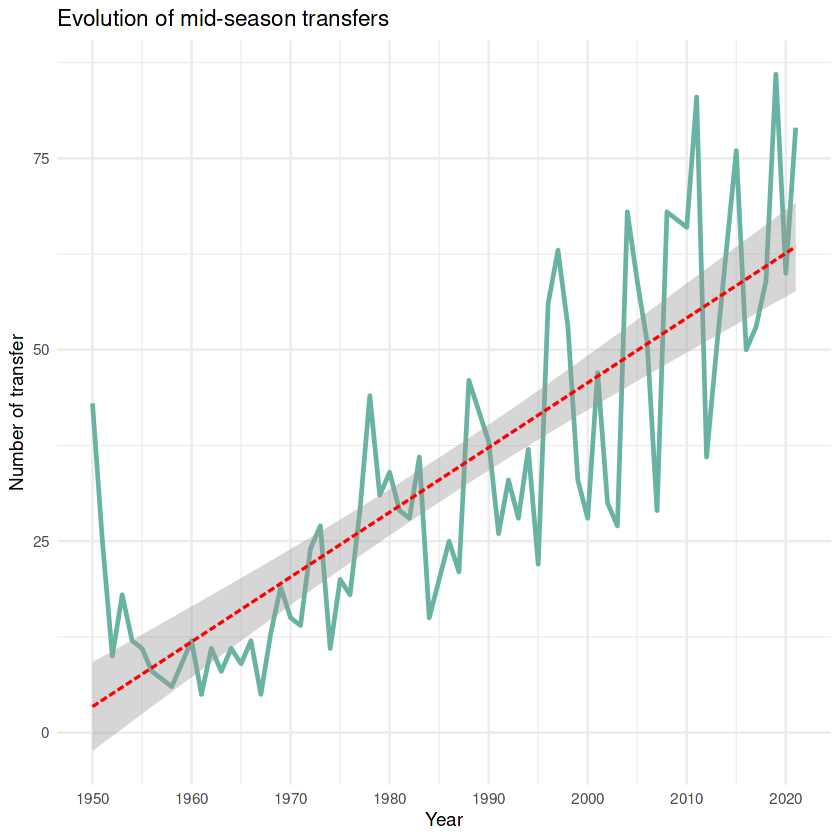

In [22]:
ggplot(transfer, aes(Year, n)) +
  geom_line( color="#69b3a2", linewidth=1, alpha=1, linetype=1) +
  scale_x_continuous(breaks = seq(1950, 2021, 10)) +
  geom_smooth(method = lm, color="red", linetype = 5, linewidth = 0.7, se = T) +
  labs(title="Evolution of mid-season transfers", 
       y="Number of transfer", 
       x="Year")+
  theme_minimal()

## Physique
Over time, there has been a significant transformation in the way athletes physically present themselves on the basketball court. From the 1980s to the present day, there has been a trend toward increasingly taller, more athletic, and more muscular players. This evolution has been driven by a combination of factors, including the advancement of training techniques, the increasing focus on the importance of physical fitness, and the adoption of targeted dietary regimens.

In the 1980s and 1990s, the game was dominated by tall, physically imposing players such as Shaquille O'Neal and Hakeem Olajuwon. However, with the arrival of the new millennium, we saw the emergence of a new generation of players who combined height with agility and versatility. This paradigm shift led to an increased demand for players who could cover multiple positions on the court and contribute on both defense and offense.

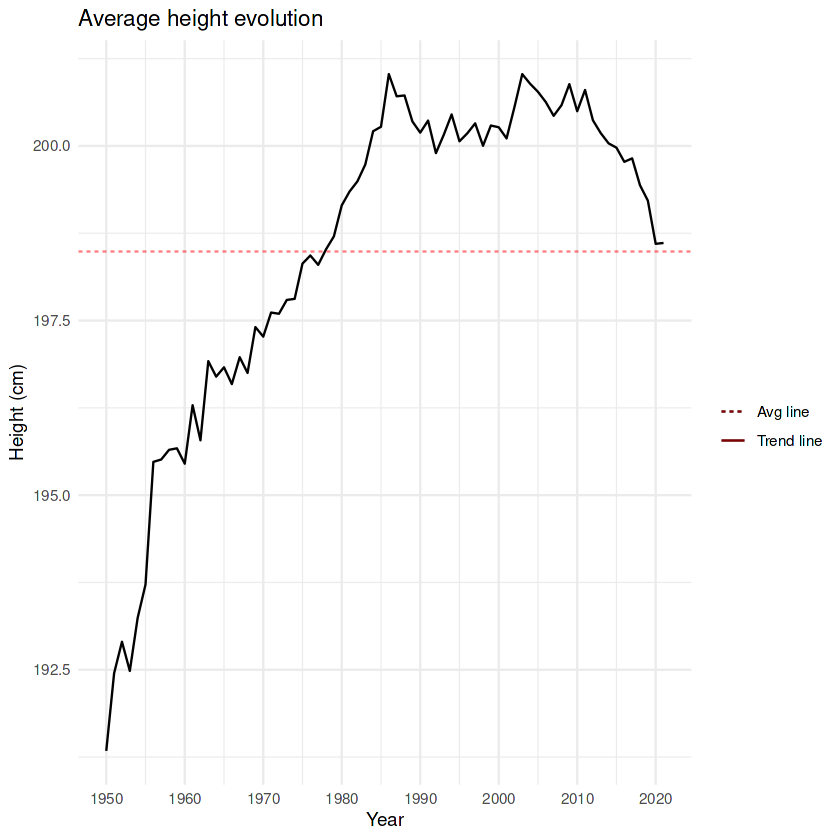

In [23]:
avg <- nba_withTOT %>% 
  group_by(Year) %>% 
  summarise("Height"=mean(Ht, na.rm = T), "Weight"=mean(Wt, na.rm = T))

ggplot(avg, aes(x=Year, y=Height, linetype = "Trend line")) +
  geom_line()+
  labs(x="Year", y="Height (cm)", title = "Average height evolution")+
  geom_hline(aes(yintercept = mean(Height), linetype = "Avg line"), col = "red", alpha = 0.5) +
  scale_x_continuous(breaks = seq(1950, 2021, 10)) +
  scale_linetype_manual(name = "", values = c(2, 1))+
  theme_minimal()

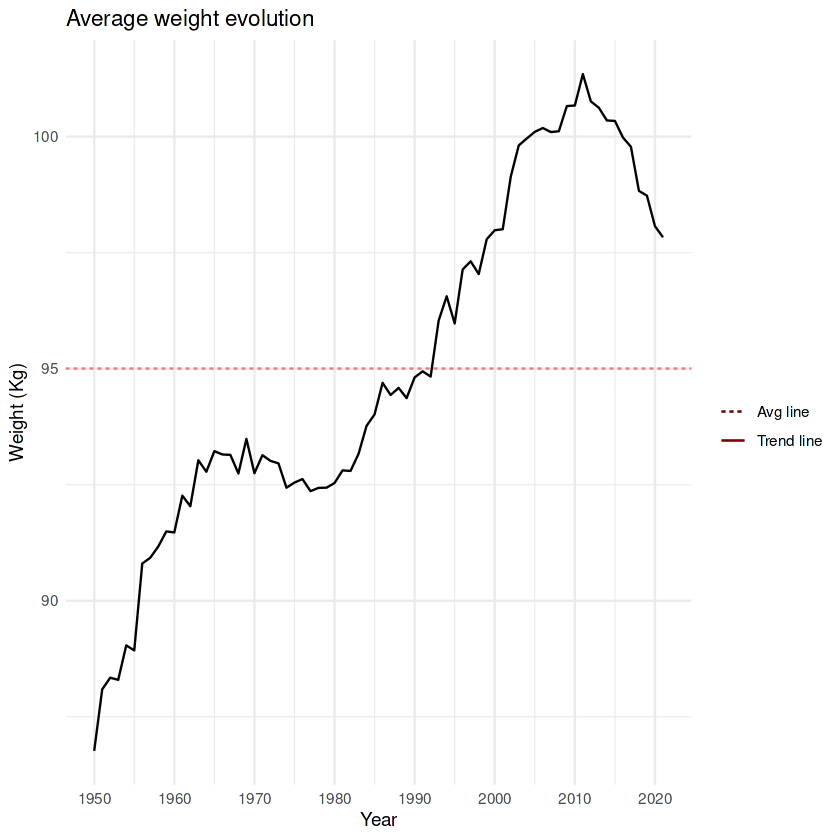

In [24]:
ggplot(avg, aes(x=Year, y=Weight, linetype = "Trend line")) +
  geom_line()+
  labs(x="Year", y="Weight (Kg)", title = "Average weight evolution")+
  geom_hline(aes(yintercept = mean(Weight), linetype = "Avg line"), col = "red", alpha = 0.5) +
  scale_x_continuous(breaks = seq(1950, 2021, 10)) +
  scale_linetype_manual(name = "", values = c(2, 1))+
  theme_minimal()

## '50 years and 24 seconds rule
In the 1950s, the NBA introduced one of the most revolutionary rules in professional basketball history: the 24-second rule. This innovation was implemented to counter the slow, defensive game that dominated the era, opening the door to a faster, more spectacular, high-scoring game. The 24-second rule transformed the way the game was played, prompting teams to develop more efficient offensive strategies and adopt a more dynamic style of play. This rule helped make the NBA a more engaging sports experience for players and fans alike, ushering in an era of great innovation and fun on the basketball court.

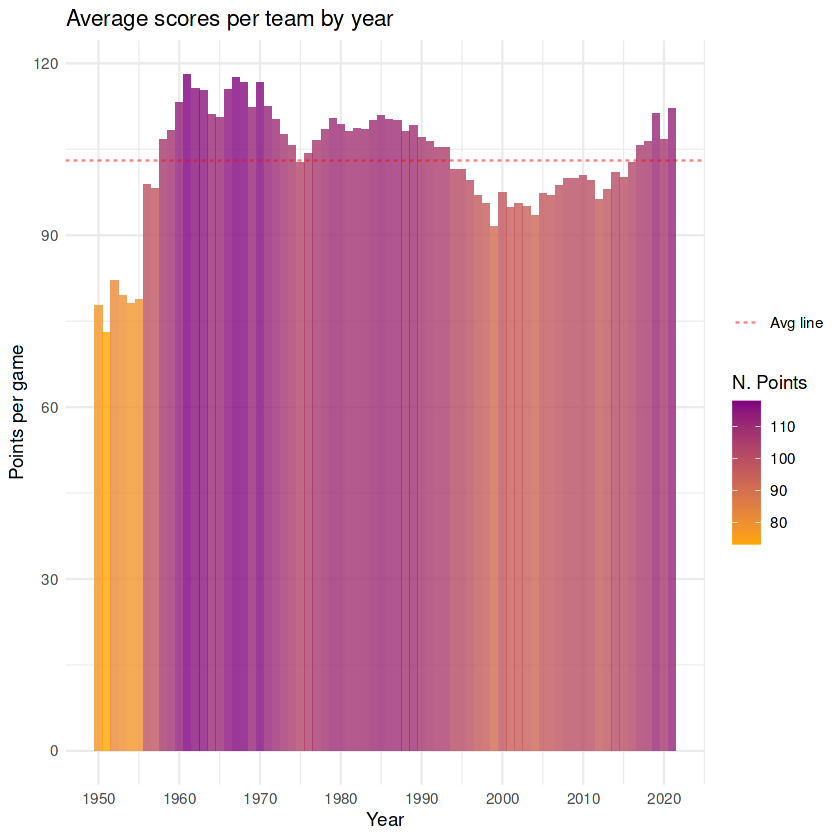

In [25]:
Team_Scores <- nba %>%
  filter(!Tm == "TOT") %>% 
  group_by(Year) %>%
  summarise(Tot_PTS = sum(PTS),
            nTeam = n_distinct(Tm),
            nGames = max(G),
            Tot_G = round((nGames*nTeam)/2, 0),
            avg_Tm_Scores = round((Tot_PTS/Tot_G)/2, 2)) 

Team_Scores %>%
  group_by(Year) %>%
  ggplot(aes(Year, avg_Tm_Scores, fill=avg_Tm_Scores)) + 
  geom_bar(stat="identity", alpha=0.8) +
  scale_fill_gradient(name = "N. Points",low = "#FFA500", high = "#800080") +
  geom_hline(aes(yintercept = mean(Team_Scores$avg_Tm_Scores),linetype = "Avg line"), col = "red", alpha = 0.5) +
  labs(title = "Average scores per team by year", x = "Year", y ="Points per game")+
  scale_x_continuous(breaks = seq(1950, 2021, 10)) +
  scale_linetype_manual(name = "", values = 2)+
  theme_minimal()

## '60 years and best rebounders
In the 1960s, the NBA experienced a golden age marked by great players and significant changes in the way basketball was played. This decade witnessed some of the game's greatest legends, including Wilt Chamberlain, Bill Russell, Jerry West, Oscar Robertson and Elgin Baylor. In particular, Chamberlain and Russell were absolute dominators under the boards, setting impressive rebounding records and leading their respective teams to numerous successes. Their epic rivalry defined an entire era of basketball and captured the imagination of fans around the world. These players not only left an indelible imprint on NBA history, but also helped shape the way the game was played and enjoyed for decades to come.

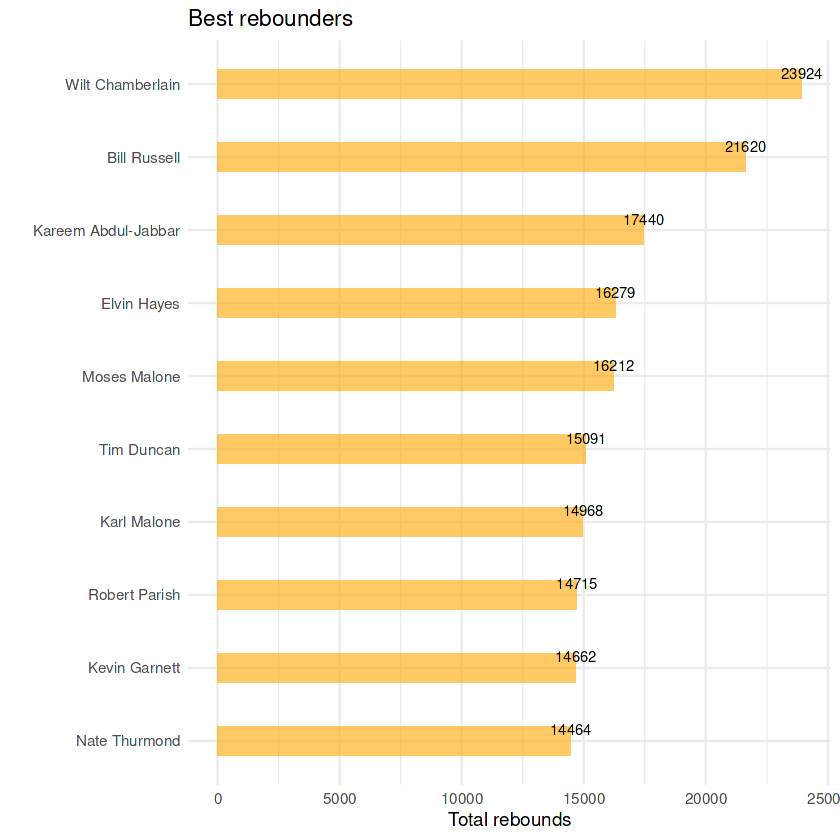

In [26]:
tot_rbd <- nba_withTOT %>% 
  group_by(Player) %>% 
  summarise("SumRebounds"=sum(TRB)) %>% 
  arrange(desc(SumRebounds)) %>% 
  head(10) 

tot_rbd %>% 
  arrange(SumRebounds) %>% 
  mutate(Player=factor(Player,levels=Player)) %>% 
  ggplot( aes(x=Player, y=SumRebounds)) +
  geom_bar(stat="identity", fill="orange", alpha=.6, width=.4) +
  coord_flip() +
  xlab("")+
  ylab("Total rebounds")+
  geom_text(aes(label=SumRebounds), vjust = -0.5, size = 3)+
  ggtitle("Best rebounders")+
  theme_minimal()

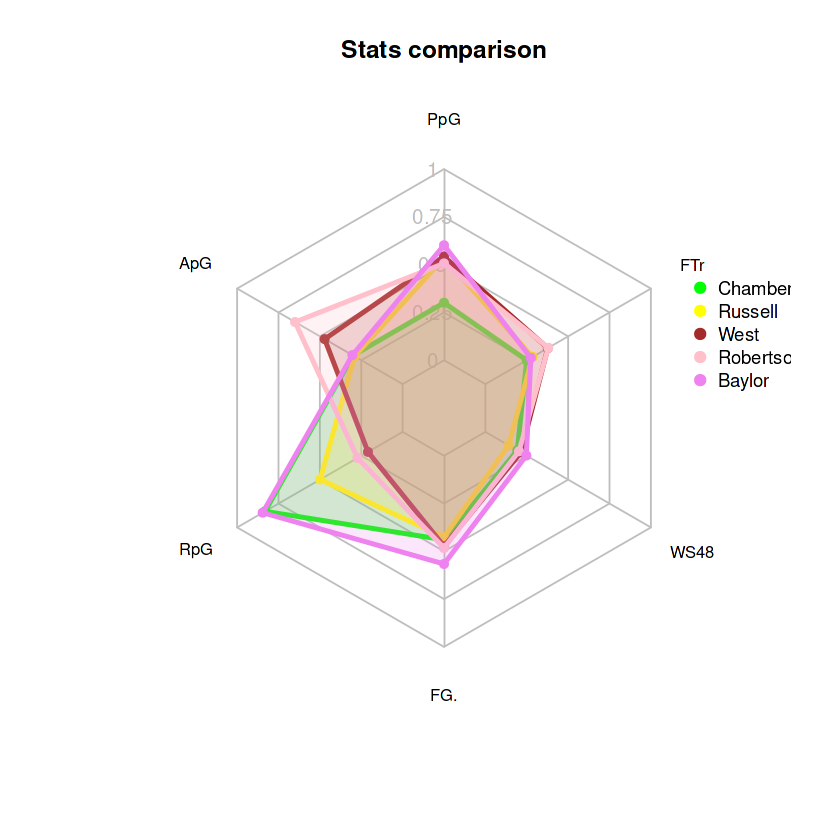

In [27]:
RC <- nba_performance %>%
  filter(Player %in% c("Wilt Chamberlain", "Bill Russell", 
                       "Jerry West", "Oscar Robertson", "Elgin Baylor")) %>% 
  group_by(Player) %>% 
  summarise("PpG" = mean(PpG)/max(nba$PpG), "ApG"=mean(ApG)/max(nba$ApG),
            "RpG"=mean(RpG)/max(nba$RpG, na.rm = T),
            "FG."=mean(FG.),"WS48"=mean(WS.48), "FTr" = mean(FTr)) %>% 
  select(-Player)

RC <- rbind(rep(1,6), rep(0,6), RC)
colors_border=c("green", "yellow", "brown", "pink", "violet")
colors_in=c(adjustcolor("green", alpha.f = 0.2), adjustcolor("yellow", alpha.f = 0.2),
            adjustcolor("brown", alpha.f = 0.2), adjustcolor("pink", alpha.f = 0.2), 
            adjustcolor("violet", alpha = 0.2))

radarchart( RC, axistype=1, title = "Stats comparison",
            pcol=colors_border , pfcol=colors_in , plwd=3, plty=1 , 
            cglcol="grey", cglty=1, axislabcol="grey", caxislabels=seq(0,1,0.25), cglwd=1.1,
            vlcex=0.8)

legend(x=1, y=0.6, legend = c("Chamberlain", "Russell", "West", "Robertson", "Baylor"), bty = "n", pch=20 , 
       col=colors_border , text.col = "black", cex=0.9, pt.cex=1.6)

## '70 years and best scorers
In the 1970s, the NBA witnessed a diversification of the game and a new dominance of talent. One of the key players of this decade was Kareem Abdul-Jabbar, then known as Lew Alcindor. Jabbar brought a unique combination of height, agility and skill to the game, becoming one of the most dominant basketball players of the era. His signature "skyhook" was a lethal weapon under the basket, allowing him to become the all-time leading scorer in NBA history, a record he held until LeBron James surpassed him in 2023. In addition to Jabbar, the 1970s saw the emergence of other stars of the caliber of Julius Erving, Walt Frazier, and George Gervin, who helped define an era of great spectacle and innovation in professional basketball.

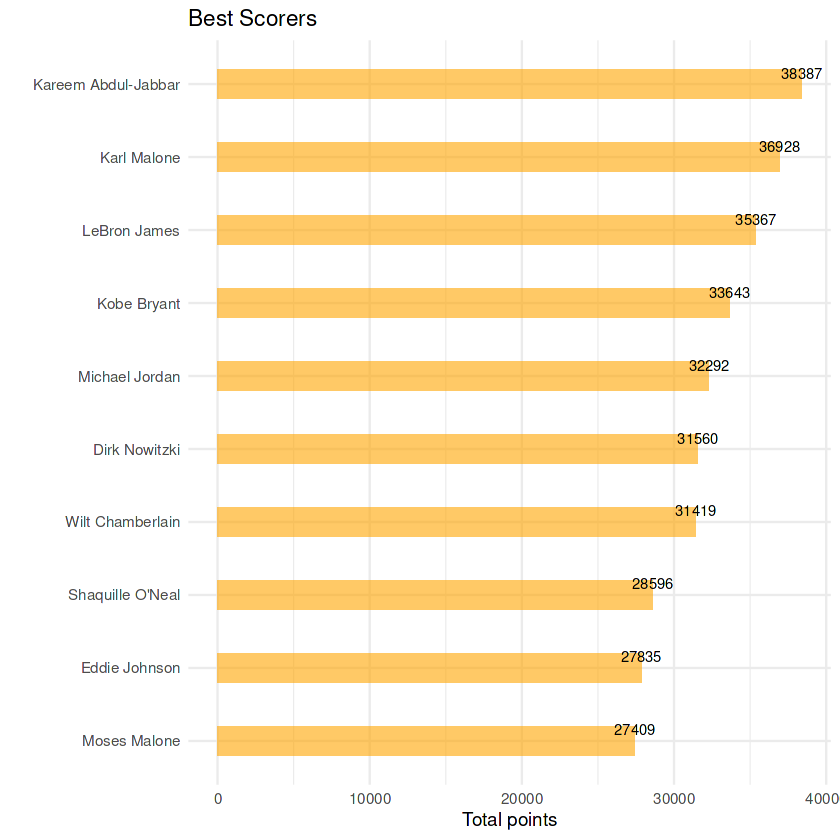

In [28]:
tot_pts <- nba_withTOT %>% 
  group_by(Player) %>% 
  summarise("SumPts"=sum(PTS)) %>% 
  arrange(desc(SumPts)) %>% 
  head(10) 

tot_pts %>% 
  arrange(SumPts) %>% 
  mutate(Player=factor(Player,levels=Player)) %>% 
  ggplot( aes(x=Player, y=SumPts)) +
  geom_bar(stat="identity", fill="orange", alpha=.6, width=.4) +
  coord_flip() +
  xlab("")+
  ylab("Total points")+
  geom_text(aes(label=SumPts), vjust = -0.5, size = 3)+
  ggtitle("Best Scorers")+
  theme_minimal()

## '80 years and three points
In the 1980s, the NBA experienced a golden era characterized by a great rivalry between teams and an incredible array of talent. One of the hallmarks of this decade was the increased importance of assists in the game, with players such as Magic Johnson of the Los Angeles Lakers and Isiah Thomas of the Detroit Pistons redefining the point guard role. Johnson, with his spectacular style and unique game vision, became one of the best distributors of assists in league history, helping to shape the identity of the 1980s Lakers. At the same time, the introduction of the three-point shot added a new strategic element to the game, allowing teams to spread the court and create spaces for shooters. This led to greater diversification of offensive tactics and made the game even more spectacular for fans. The 1980s featured a number of great teams and basketball legends, helping to make this decade one of the most memorable periods in NBA history.

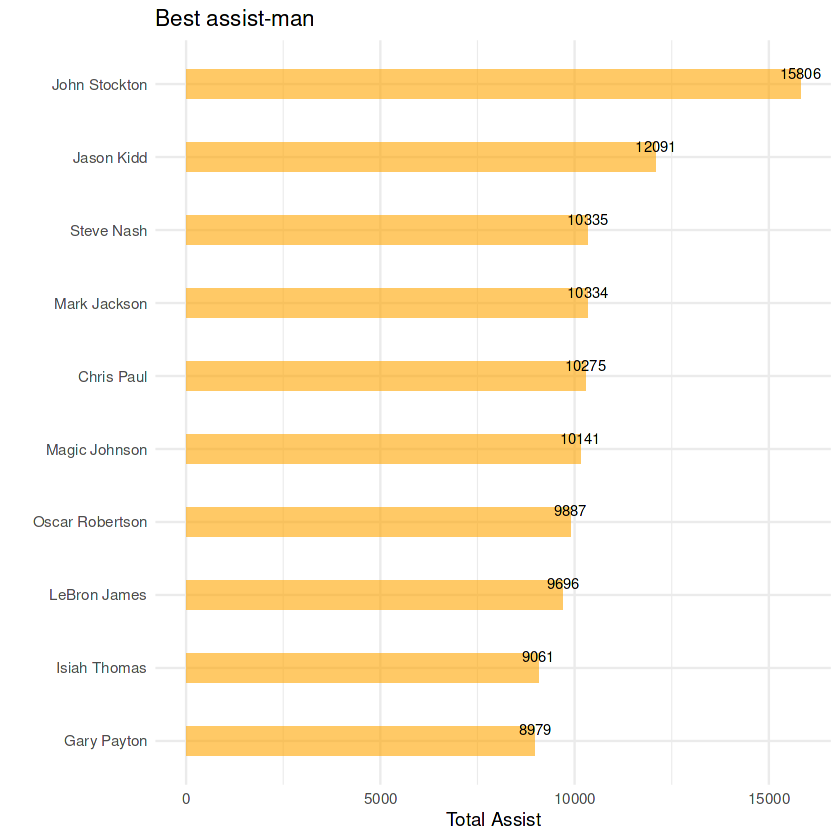

In [29]:
tot_ast <- nba_withTOT %>% 
  group_by(Player) %>% 
  summarise("SumAst"=sum(AST)) %>% 
  arrange(desc(SumAst)) %>% 
  head(10)

tot_ast %>%
  arrange(SumAst) %>% 
  mutate(Player=factor(Player, levels=Player)) %>% 
  ggplot(aes(x=Player, y=SumAst))+
  geom_bar(stat="identity", fill="orange", alpha=.6, width=.4)+
  coord_flip()+
  xlab("")+
  ylab("Total Assist")+
  geom_text(aes(label=SumAst), vjust = -0.5, size = 3)+
  ggtitle("Best assist-man")+
  theme_minimal()

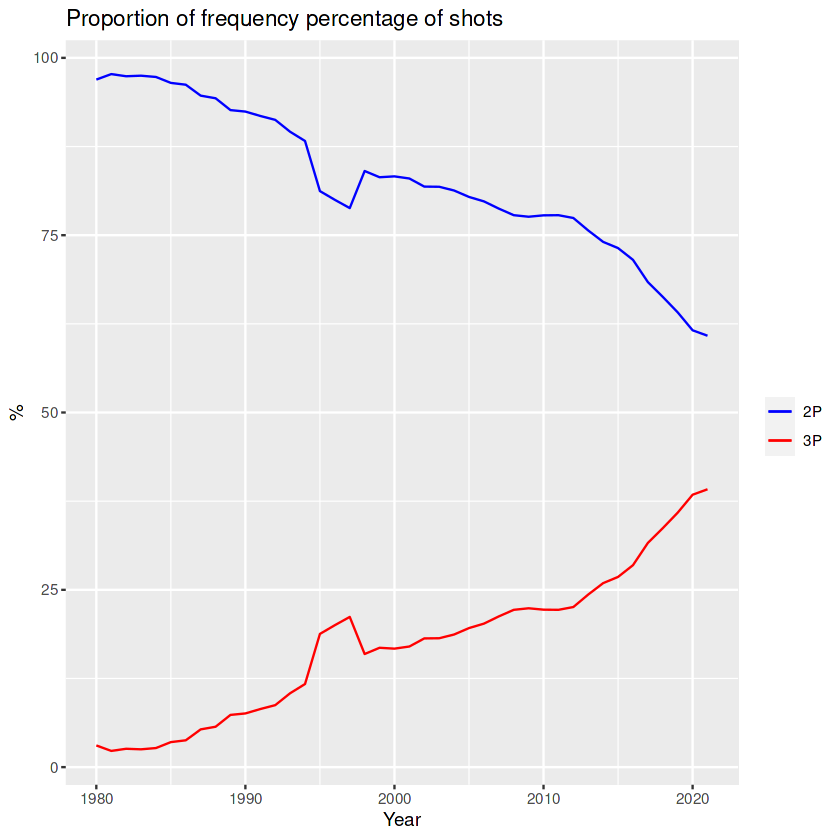

In [30]:
shoot <- nba_withTOT %>% 
  filter(Year > 1979) %>%
  group_by(Year) %>% 
  summarise("X2P"=(sum(X2PA)/(sum(X2PA)+sum(X3PA)))*100, 
            "X3P"=(sum(X3PA)/(sum(X2PA)+sum(X3PA)))*100)

ggplot(shoot, aes(x = Year)) +
  geom_line(aes(y = X2P, color = "2P")) +
  geom_line(aes(y = X3P, color = "3P")) +
  scale_color_manual(values = c("2P" = "blue", "3P" = "red"), name = "") +
  labs(title = "Proportion of frequency percentage of shots", x = "Year", y = "%")

## '90 Years and Chicago Bulls
In the 1990s, the NBA was dominated by the legendary dynasty of the Chicago Bulls, led by the legendary Michael Jordan. This decade was marked by an extraordinary supremacy of the Bulls, who won six NBA titles in eight years, from 1991 to 1998. Michael Jordan became the epitome of world basketball, with his extraordinary style of play and unparalleled leadership making him one of the most iconic players of all time. Alongside Jordan, the Bulls boasted a roster of outstanding talent, including Scottie Pippen, Dennis Rodman, and coach Phil Jackson, who helped make the team one of the most fearsome in NBA history. The Bulls dynasty not only dominated the decade, but also had a lasting impact on popular culture, transforming basketball into a global sport and inspiring a generation of young players. 

In [31]:
nba %>% 
  filter(Tm == "CHI" & (Year > 1990 & Year < 1999) & 
           Player %in% c("Michael Jordan", "Scottie Pippen","Dennis Rodman","Horace Grant", "Steve Kerr")) %>% 
  group_by(Player) %>% 
  summarise(MPG = round(mean(MpG),1), PPG = round(mean(PpG),1), 
            APG = round(mean(ApG),1), RPG = round(mean(RpG),1), 
            FPG = round(mean(FpG),1), BPG = round(mean(BpG),1), 
            TOPG = round(mean(TOpG),1), SPG = round(mean(SpG),1))

Player,MPG,PPG,APG,RPG,FPG,BPG,TOPG,SPG
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Dennis Rodman,34.6,5.3,2.8,15.3,3.1,0.3,2.0,0.6
Horace Grant,35.4,13.8,2.7,9.7,2.5,1.2,1.3,1.2
Michael Jordan,38.4,30.0,4.9,6.3,2.4,0.7,2.3,2.2
Scottie Pippen,37.8,20.0,5.9,7.2,2.9,0.9,2.9,2.2
Steve Kerr,23.1,8.2,2.2,1.5,1.3,0.0,0.6,0.7


## 2000 years and Kobe
In the 2000s, one of the NBA's brightest stars was Kobe Bryant, who brought out a constant comparison with legend Michael Jordan. Bryant, nicknamed "Black Mamba," was an extraordinary player who carried on Jordan's legacy with his outstanding style of play and tireless work ethic. During this decade, Bryant led the Los Angeles Lakers to several successes, winning five NBA titles and cementing his status as one of the greatest players of all time. Comparisons between Bryant and Jordan were inevitable, as both boasted extraordinary scoring skills, a winning mentality and unmatched determination on the court. While Bryant sought to emulate Jordan's game, he also developed a unique style all his own, becoming an iconic figure in his own right. 

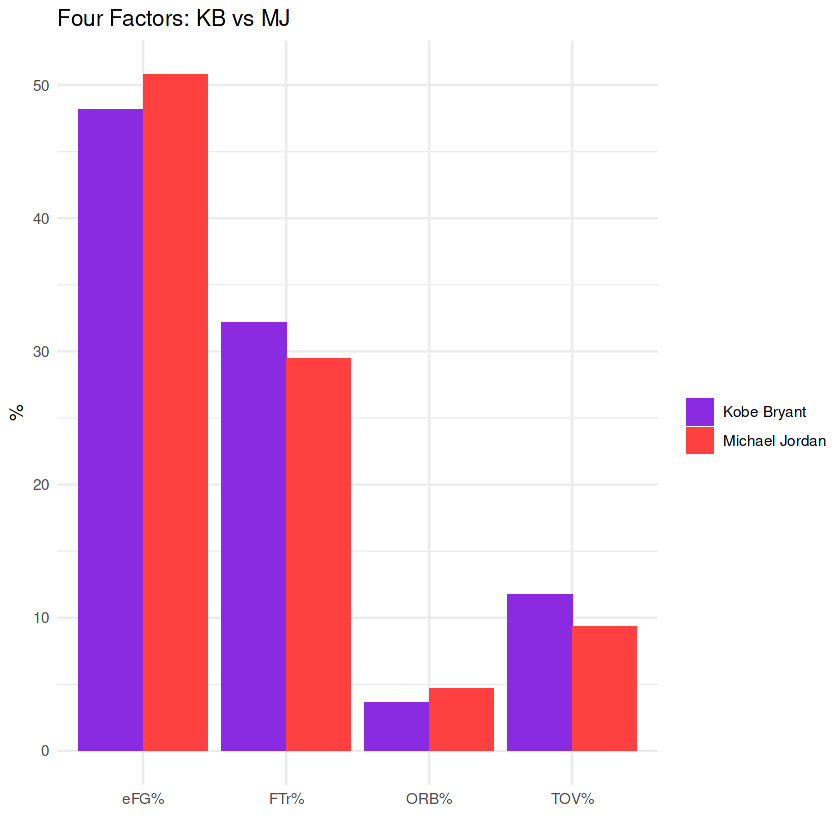

In [32]:
BJ <- nba_performance %>%
  filter(Player == "Kobe Bryant" | Player == "Michael Jordan") %>% 
  group_by(Player) %>% 
  summarise("eFG%"=mean(eFG.)*100, "FTr%"=mean(FTr)*100,
            "TOV%"= mean(TOV.), 
            "ORB%"= mean(ORB.))

#grouped barplot
df1 <- data.frame(stats = rep(c("eFG%", "FTr%", "TOV%", "ORB%"), each = 2),
                  Player = rep(BJ$Player, times = 4),
                  value = c(BJ$`eFG%`,BJ$`FTr%`, BJ$`TOV%`, BJ$`ORB%`))

ggplot(df1, aes(fill = Player, y = stats, x = value))+
  geom_bar(position = "dodge", stat = "identity")+
  ggtitle("Four Factors: KB vs MJ")+
  coord_flip()+
  scale_fill_manual(values = c("blueviolet","brown1" ))+
  xlab("%")+
  ylab("")+
  theme(legend.position = "right")+
  labs(fill = "")+
  theme_minimal()

## 2010 to date
In the 2010s and up to the present day, the NBA has seen an increasing trend toward three-point shooting, with players like Stephen Curry redefining the way the game is played. Curry, in particular, has helped transform the concept of "shooter" with his revolutionary style of play and deadly accuracy from behind the arc. In 2019, Curry surpassed the record for triples made by longtime arcade player Ray Allen, solidifying his status as one of the best shooters in the history of the game. This shift in the professional basketball landscape has seen an evolution in teams' offensive approaches, with an increasing emphasis on space and the ability to shoot from farther distances. The rise of Curry and other elite shooters has led to a new era of game dynamics, where the constant threat of the three-point shot has made defenses more tense and opened up space for other offensive plays. This trend has had a significant impact on the way basketball is played and has made the three-point shot a key component of the game strategies of successful teams.

Warning message:
“ggrepel: 19 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


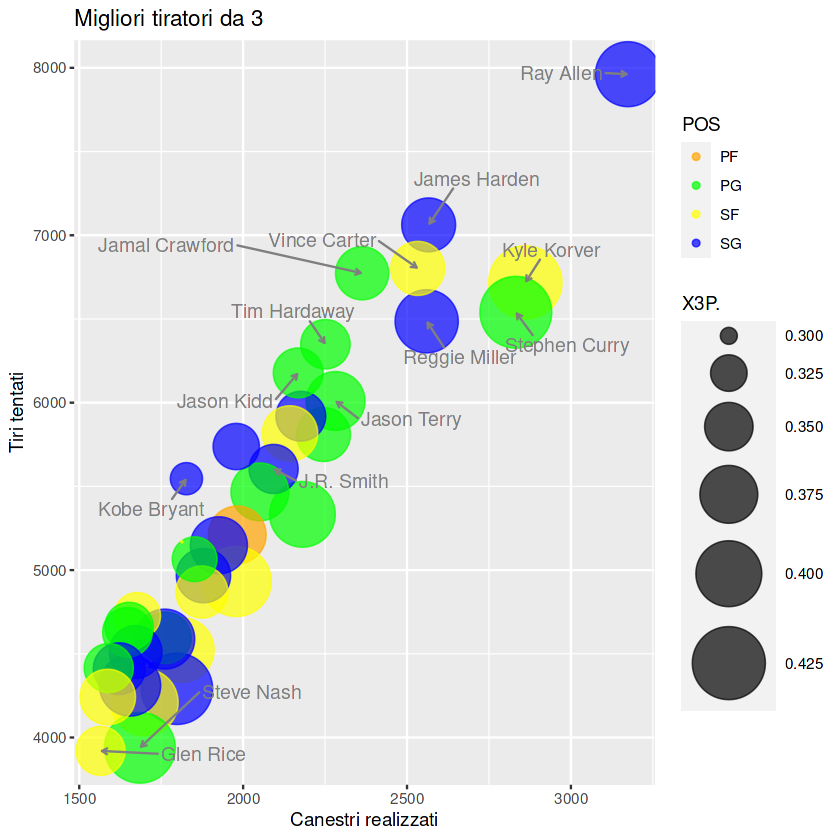

In [33]:
nba %>% 
  group_by(Player) %>% 
  reframe("X3P"=sum(X3P), "X3P."=mean(X3P.), "X3PA"= sum(X3PA), "POS"= Pos) %>% 
  distinct(Player, .keep_all = T) %>% 
  arrange(desc(X3P)) %>% 
  head(40) %>% 
  ggplot(aes(x=X3P, y=X3PA, size = X3P., color = POS)) +
  scale_color_manual(values = PosColorCode)+
  labs(title="Migliori tiratori da 3", x = "Canestri realizzati", y="Tiri tentati")+
  geom_point(alpha=0.7)+
  scale_size(range = c(0, 20))+
  geom_text_repel(
    aes(label = Player), size = 4,
    box.padding = 1,
    #max.overlaps = Inf,
    arrow = arrow(length = unit(0.010, "npc")),
    nudge_x = .15,
    nudge_y = .5,
    color = "grey50"
  )

# Conclusions
In conclusion, the descriptive analysis of the dataset not only provides a detailed picture of the history of the league, but can also serve as a springboard for deeper insights and more sophisticated analyses that contribute to our understanding of the game and its players. For example, it might be interesting to take a closer look at the factors that influence the induction of players into the Hall of Fame, identifying the key characteristics and performances that distinguish them from their peers. In addition, the application of clustering techniques could be explored to group players based on their characteristics and playing styles, allowing a better understanding of the differences and similarities among them.